In [1]:
import numpy as np
#import scipy.io
import torch
import os
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
#import netCDF4 as nc
#from prettytable import PrettyTable
#from count_trainable_params import count_parameters    
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.transforms import ScaledTranslation

from nn_FNO import FNO1d
#from nn_MLP import MLP_Net
from nn_step_methods import *
from hyper_fno import HyperNetwork
from fvcore.nn import FlopCountAnalysis

2.5.1
2.5.1
2.5.1


In [21]:
def Dataloader(data,batch_size,batch_time, key):
    time_chunks = []
    for i in range(data.shape[0] - batch_time*lead):
        time_chunks.append(data[i:i+batch_time*lead:lead])
    extra = len(time_chunks) % batch_size
    if extra==0:
        time_chunks = np.array(time_chunks)
    else:
        time_chunks = np.array(time_chunks[:-extra])
    rng = np.random.default_rng(key)
    time_chunks = rng.permutation(time_chunks)
    split = np.array(np.split(time_chunks,time_chunks.shape[0]//batch_size))
    return split


device = 'cuda'
skip_factor = 0 #Number of timesteps to skip (to make the saved data smaller), set to zero to not save a skipped version

time_step_4_data = 1e-3
lead = int((1/1e-3)*time_step_4_data)
print(lead,'lead')

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    data = pickle.load(f)
    print(data.shape)
data=np.asarray(data[:,:250000])
print(data.shape)
trainN=150000 #dont explicitly need this as no training is done in file
input_size = 1024
output_size = 1024

input_test_torch = torch.from_numpy(np.transpose(data[:,trainN:])).to(device)
print(input_test_torch.shape)
num_init_conds = 100
M_full = 50000


inds = torch.randint((input_test_torch.shape[0] - (M_full)), size=(num_init_conds,))
print('before load')
label_multi_full = torch.zeros([0, M_full//100, 1024]).to(device)

for ind in inds:
    label_multi_full = torch.cat([label_multi_full, input_test_torch[ind:ind+M_full:100].unsqueeze(0)], dim=0)

#label_multi_full = torch.cat([label_multi_full, input_test_torch[0:M_full:100].unsqueeze(0)], dim=0)
#label_multi = label_multi_full[:,::100].float()
#print(label_multi.shape)
print('After load')
print(label_multi_full.shape)

1 lead
(1024, 300000)
(1024, 250000)
torch.Size([100000, 1024])
before load
After load
torch.Size([100, 500, 1024])


In [31]:
time_step = 1e-1
lead = int((1/1e-3)*time_step)
num_iters = 4
M = int(M_full/lead)
print(lead,'lead ', M)

#Hyper parameter testing models

#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_64_MLP_4Layers_ExponentialLR_100_train_multistep/chkpt_HFNO_Width_64_MLP_4Layers_ExponentialLR_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_32_MLP_7Layers_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_32_MLP_7Layers_No_Spectral_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_8_MLP_20Layers_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_8_MLP_20Layers_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_32_MLP_7Layers_ExponentialLR_100_train_multistep/chkpt_HFNO_Width_32_MLP_7Layers_ExponentialLR_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_32_MLP_14Layers_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_32_MLP_14Layers_No_Spectral_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_1.5_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_1.5_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_8_MLP_32Layers_HyperHidden_2.0_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_8_MLP_32Layers_HyperHidden_2.0_No_Spectral_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_3.0_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_3.0_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_2.75_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_2.75_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_2.25_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_2.25_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_32Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_32Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_32_MLP_32Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_32_MLP_32Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_20Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_20Layers_HyperHidden_2.5_No_Spectral_Updates_100_train_multistep_epoch_240.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_20Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_20Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep_epoch_220.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_10Layers_HyperHidden_2.5_Rank1_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_10Layers_HyperHidden_2.5_Rank1_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_10Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_10Layers_HyperHidden_2.5_Rank2_Updates_100_train_multistep_epoch_250.pt"


#Rank Testing Models
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/HFNO_Width_16_MLP_14Layers_No_Spectral_Updates_100_train_multistep/chkpt_HFNO_Width_16_MLP_14Layers_No_Spectral_Updates_100_train_multistep_epoch_200.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank2_Updates_100_train_multistep/chkpt_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank2_Updates_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank3_Updates_100_train_multistep/chkpt_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank3_Updates_100_train_multistep_epoch_210.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank4_Updates_100_train_multistep/chkpt_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank4_Updates_100_train_multistep_epoch_230.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank5_Updates_100_train_multistep/chkpt_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_Rank5_Updates_100_train_multistep_epoch_210.pt"

#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/No_Bias_Updates_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_R1_Updates_100_train_multistep/chkpt_No_Bias_Updates_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_R1_Updates_100_train_multistep_epoch_300.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/Last_Parameters_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_R1_Updates_100_train_multistep/chkpt_Last_Parameters_FNO_Width_16_MLP_14Layers_HyperHidden_2.0_R1_Updates_100_train_multistep_epoch_250.pt"

#Theory Testing
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_64_Iters_16_100_train_multistep/chkpt_FNO_Width_64_Iters_16_100_train_multistep_epoch_250.pt"
net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_64_Iters_4_100_train_multistep/chkpt_FNO_Width_64_Iters_4_100_train_multistep_epoch_250.pt"
#net_file_name = "/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_64_Iters_0_100_train_multistep/chkpt_FNO_Width_64_Iters_0_100_train_multistep_epoch_250.pt"



#FNO Width 256 Model
#fno_file_name = "/glade/derecho/scratch/erantala/project_runs/chkpt_FNO_Eulerstep_implicit_lead100_v2_epoch38.pt"
print(net_file_name)


step_func = Switch_Euler_step #this determines the step funciton used in the eval step, has inputs net (pytorch network), input batch, time_step
print(step_func)
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    data = pickle.load(f)
data=np.asarray(data[:,:250000])

#model parameters
input_size = 1024
output_size = 1024
hyper_hidden_scale = 2
modes = 256 # number of Fourier modes to multiply
width = 64  # input and output chasnnels to the FNO layer
device = "cuda"
num_mlp_layers = 14
which_params = ["fc0.weight", "fc0.bias", "w0.weight", "w0.bias", "w1.weight", "w1.bias", "w2.weight", "w2.bias", "w3.weight", "w3.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias"]
#which_params = ["fc2.weight", "fc2.bias"]
rank = 1

my_net = FNO1d(modes, width, 1, 1)
#my_fno = FNO1d(modes, 256, 1, 1)
#my_hypernet = HyperNetwork(num_mlp_layers, input_size, hyper_hidden_scale, which_params, rank, my_net, device)
ckpt = torch.load(net_file_name, map_location=device, weights_only = True)
#my_hypernet.load_state_dict(ckpt["my_hypernet"])
my_net.load_state_dict(ckpt["mynet"])
#my_fno.load_state_dict(torch.load(fno_file_name, map_location = device, weights_only=True))

step_method = step_func(my_net, None, device, num_iters,time_step).to(device)
#fno_step_method = step_func(my_fno, my_hypernet, device, num_iters,time_step).to(device)

#step_method.load_state_dict(torch.load(net_file_name, map_location=torch.device(device)))


100 lead  500
/glade/derecho/scratch/erantala/project_runs/model_chkpts/FNO_Width_64_Iters_4_100_train_multistep/chkpt_FNO_Width_64_Iters_4_100_train_multistep_epoch_250.pt
<class 'nn_step_methods.Switch_Euler_step'>


In [6]:
from math import log2

def _shape_from_value(v):
    t = getattr(v, "type", lambda: None)()
    sizes = getattr(t, "sizes", lambda: None)()
    if not sizes or any(d is None for d in sizes):
        return None
    return [int(d) for d in sizes]

def _to_int_or_none(v):
    try:
        iv = v.toIValue()
        return int(iv) if isinstance(iv, int) else None
    except Exception:
        return None

def _prod(seq):
    out = 1
    for s in seq:
        out *= int(s)
    return out

#using the approximation complex FFT - 5*N*log2(N).
#real rFFT/iRFFT - (5/2)*N*log2(N).
C_RFFT = 2.5
C_IRFFT = 2.5

def rfft_flop_jit(inputs, outputs):
    shape = _shape_from_value(inputs[0])
    if not shape:
        return 0

    n = _to_int_or_none(inputs[1])
    dim = _to_int_or_none(inputs[2])
    if dim is None:
        dim = -1
    if dim < 0:
        dim += len(shape)

    N = n if (n is not None and n != -1) else int(shape[dim])
    if N <= 1:
        return 0

    num_transforms = _prod(shape[:dim] + shape[dim+1:])
    flops_per = C_RFFT * N * log2(N)
    return int(num_transforms * flops_per)

def irfft_flop_jit(inputs, outputs):
    shape = _shape_from_value(inputs[0])
    if not shape:
        return 0

    n = _to_int_or_none(inputs[1])
    dim = _to_int_or_none(inputs[2])
    if dim is None:
        dim = -1
    if dim < 0:
        dim += len(shape)

    if n is not None and n != -1:
        N = n
    else:
        M = int(shape[dim]) 
        N = max(0, 2 * (M - 1))
    if N <= 1:
        return 0

    num_transforms = _prod(shape[:dim] + shape[dim+1:])
    flops_per = C_IRFFT * N * log2(N)
    return int(num_transforms * flops_per)
    
def _numel_from_value(v):
    t = v.type()
    sizes = t.sizes() if hasattr(t, "sizes") else None
    if sizes is None:
        return 0
    n = 1
    for d in sizes:
        if d is None:
            return 0
        n *= int(d)
    return n


def _flops_from_outputs(outputs, which=0):
    if not outputs or which >= len(outputs):
        return 0
    return _numel_from_value(outputs[which])

#using 8 as approximation
def gelu_flop_jit(inputs, outputs):
    return 8 * _flops_from_outputs(outputs, 0)

def mul_flop_jit(inputs, outputs):
    return _flops_from_outputs(outputs, 0)

def add_flop_jit(inputs, outputs):
    return _flops_from_outputs(outputs, 0)


my_hypernet.eval()
my_net.eval()
with torch.no_grad():
    fca = FlopCountAnalysis(my_hypernet, (torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1))))
    fca.set_op_handle("aten::gelu", gelu_flop_jit)
    fca.set_op_handle("aten::fft_rfft",  rfft_flop_jit)
    fca.set_op_handle("aten::fft_irfft", irfft_flop_jit)
    fca.set_op_handle("aten::mul", mul_flop_jit)
    fca.set_op_handle("aten::add", add_flop_jit)
    fno_fca = FlopCountAnalysis(my_net, (torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1))))
    fno_fca.set_op_handle("aten::gelu", gelu_flop_jit)
    fno_fca.set_op_handle("aten::fft_rfft",  rfft_flop_jit)
    fno_fca.set_op_handle("aten::fft_irfft", irfft_flop_jit)
    fno_fca.set_op_handle("aten::mul", mul_flop_jit)
    fno_fca.set_op_handle("aten::add",add_flop_jit)
    hfno_flops_per_sample = fca.total() + (fno_fca.total() * (num_iters+1))
    hfno_flops_per_sample /= 1e12
    hfno_flops_per_sample /= num_init_conds
print(f"HFNO TFLOPS Per Sample: {hfno_flops_per_sample}")

#Testing FLOPS for Full 256 width FNO
my_fno.eval()
with torch.no_grad():
    fca2 = FlopCountAnalysis(my_fno, (torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1))))
    fca2.set_op_handle("aten::gelu", gelu_flop_jit)
    fca2.set_op_handle("aten::fft_rfft",  rfft_flop_jit)
    fca2.set_op_handle("aten::fft_irfft", irfft_flop_jit)
    fca2.set_op_handle("aten::mul", mul_flop_jit)
    fca2.set_op_handle("aten::add",add_flop_jit)
    fno_flops_per_sample = fca2.total() * (num_iters+1)
    fno_flops_per_sample /= 1e12
    fno_flops_per_sample /= num_init_conds
print(f"FNO TFLOPS Per Sample: {fno_flops_per_sample}")

torch.Size([200, 900, 1024])


The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
fno, fno.conv0, fno.conv1, fno.conv2, fno.conv3, fno.fc0, fno.fc1, fno.fc2, fno.w0, fno.w1, fno.w2, fno.w3
Unsupported operator aten::lift_fresh encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)
Unsupported operator aten::lift_fresh encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


HFNO TFLOPS Per Sample: 0.00252123692996
FNO TFLOPS Per Sample: 0.00166440513536


In [32]:
#net_pred_multi = np.zeros([num_init_conds, M-1,1024])
net_pred_multi = np.zeros([num_init_conds, 2,1024])
#net_pred_truth_multi = np.zeros([num_init_conds, M-1,1024])
#e_vec_multi_pre_eps = np.zeros([num_init_conds, M-1,1024])
#e_vec_multi = np.zeros([num_init_conds, M-1,1024])
#eps_sum_multi = np.zeros([num_init_conds, M-1,1024])

# ygrad = torch.zeros([num_init_conds, M-1, input_size, input_size])
# ygrad_truth = torch.zeros([num_init_conds, M ,input_size, input_size])


def batch_jacobian_func(input_tens):
    ygrad = torch.zeros(input_tens.shape[0], input_size, input_size)
    for num in range(0, input_tens.shape[0]):
        ygrad[num] = torch.autograd.functional.jacobian(step_method, torch.reshape(input_tens[int(num)],(1, input_size,1))).reshape(1,1024,1024)
    # ygrad = torch.func.vmap(torch.func.jacrev(step_method))(input_tens.reshape([input_tens.shape[0], input_size, 1]))
    return ygrad


label_multi = label_multi_full.float()
print(label_multi.shape)
step_method.eval()
print('Starting '+str(M))
#for k in range(0, M-1):
for k in range(0, 1):
    if k % 1000 == 0:
        print(k)
    if (k==0):

        #net_output = fno_step_method.implicit_forward_fno(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        #net_output = step_method.altered_forward(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds,input_size,1)), torch.reshape(label_multi[:,1,:].cuda(),(num_init_conds,input_size,1)))
        net_output = step_method.implicit_forward_fno(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        #net_output = step_method.hyper_implicit_forward(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        net_pred_multi [:, k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()
        
        #net_output_truth = step_method(torch.reshape(label_multi[:,0,:].cuda(),(num_init_conds, input_size,1)))
        #net_pred_truth_multi[:, k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()

        #e_vec_multi_pre_eps[:, k] = 0 
        #e_vec_multi[:, k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        #eps_sum_multi[: ,k] = (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()

    
        # ygrad[:, k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:,0,:].cuda())
        
    else:
        #net_output = fno_step_method.implicit_forward_fno(torch.reshape(torch.from_numpy(net_pred_multi[:, k-1,:]),(num_init_conds, input_size,1)).float().cuda())
        #net_output = step_method.hyper_implicit_forward(torch.reshape(torch.from_numpy(net_pred_multi[:, k-1,:]),(num_init_conds, input_size,1)).float().cuda())
        net_pred_multi [:, k,:] = torch.reshape(net_output,(num_init_conds, input_size)).detach().cpu().numpy()

        #net_output_truth, e_vec_temp = torch.func.jvp(step_method, (label_multi[:, k].reshape([num_init_conds, input_size, 1]),), (torch.tensor(e_vec_multi[:, k-1]).reshape([num_init_conds, input_size,1 ]), ))  
        #net_pred_truth_multi[:, k,:] = torch.reshape(net_output_truth,(num_init_conds, input_size)).detach().cpu().numpy()


        #e_vec_multi_pre_eps[:, k] = e_vec_temp.squeeze(2).detach().cpu().numpy()
        #e_vec_multi[:, k] += e_vec_temp.squeeze(2).detach().cpu().numpy() + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy() 

        
        #eps_sum_multi[:,k] = eps_sum_multi[:, k-1] + (net_output_truth.squeeze(-1) - label_multi[:, k+1]).detach().cpu().numpy()
        
        # ygrad[:, k] = batch_jacobian_func(torch.tensor(net_pred_multi[:, k-1,:]).float().cuda())
        # ygrad_truth[:,k] = batch_jacobian_func(label_multi[:, k, :].cuda())

print('Finished')

torch.Size([100, 500, 1024])
Starting 500
0
Finished


In [30]:
#Ranks 1-5 Testing

rank1 = net_pred_multi
#rank2 = net_pred_multi
#rank3 = net_pred_multi
#rank4 = net_pred_multi
#rank5 = net_pred_multi
#fno_pred = net_pred_multi

label_lead100 = label_multi

In [15]:
implicit_rank1 = net_pred_multi
#explicit_rank1 = net_pred_multi
#implicit_fno = net_pred_multi
#explicit_fno = net_pred_multi

#no_bias = net_pred_multi
#last_param_14 = net_pred_multi
#last_param_10 = net_pred_multi

label_lead100 = label_multi

In [33]:
#iters0 = net_pred_multi[:,0:1,:]
iters4 = net_pred_multi[:,0:1,:]
#iters16 = net_pred_multi[:,0:1,:]
label = label_multi[:,1:2,:]

(100, 1, 1024)
torch.Size([100, 1, 1024])


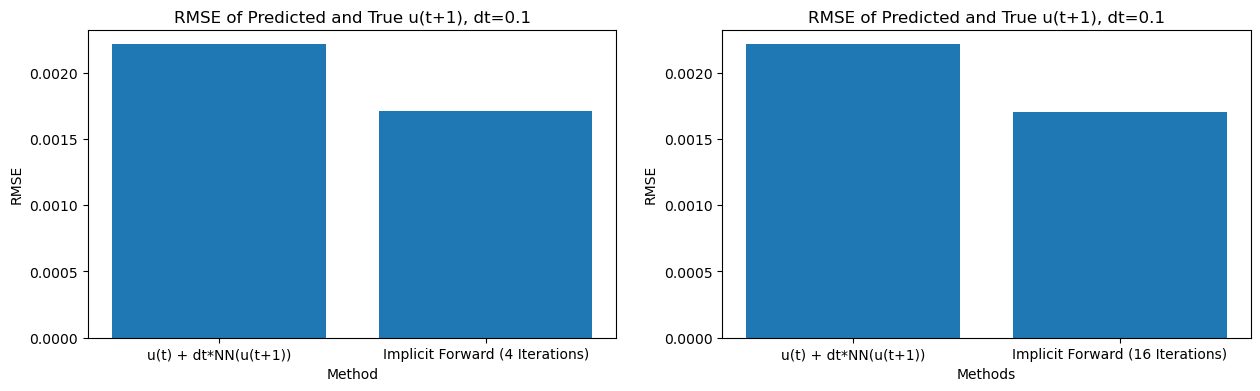

In [37]:
categories1 = ['u(t) + dt*NN(u(t+1))', 'Implicit Forward (4 Iterations)']
categories2 = ['u(t) + dt*NN(u(t+1))', 'Implicit Forward (16 Iterations)']
print(iters0.shape)
print(label.shape)
values1 = [np.sqrt(np.mean((iters0 - label.detach().cpu().numpy())**2, axis=2)).mean(0).item(), np.sqrt(np.mean((iters4 - label.detach().cpu().numpy())**2, axis=2)).mean(0).item()]
values2 = [np.sqrt(np.mean((iters0 - label.detach().cpu().numpy())**2, axis=2)).mean(0).item(),np.sqrt(np.mean((iters16 - label.detach().cpu().numpy())**2, axis=2)).mean(0).item()]
colors = ['red','blue','green']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.bar(categories1,values1)
ax1.set_xlabel('Method')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE of Predicted and True u(t+1), dt=0.1')

ax2.bar(categories2, values2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE of Predicted and True u(t+1), dt=0.1')

save_dir = "./plots"
filename = "Implicit_Forward_4_16_Test"
savepath = os.path.join(save_dir,filename)
fig.savefig(savepath, bbox_inches='tight') 

899
90.0
torch.Size([150, 900, 1024])


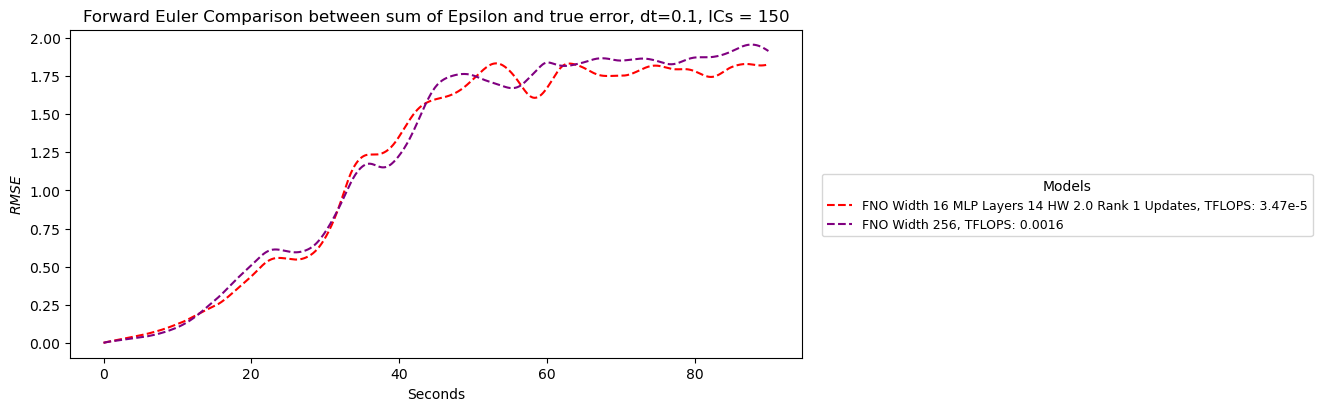

In [12]:
#rank testing plotting

trange = M-1
print(trange)
t_final = M*1e-1
print(t_final)
#print(eight_width_thirtytwo_layers_hyper_net_pred_lead100.shape)
print(label_lead100.shape)
fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

ax.plot(np.linspace(0,t_final, rank1.shape[1]), np.sqrt(np.mean((rank1[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='red', label='FNO Width 16 MLP Layers 14 HW 2.0 Rank 1 Updates, TFLOPS: 3.47e-5')
#ax.plot(np.linspace(0,t_final, rank2.shape[1]), np.sqrt(np.mean((rank2[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='blue', label='FNO Width 16 MLP Layers 14 HW 2.0 Rank 2 Updates, TFLOPS: 3.96e-5')

#ax.plot(np.linspace(0,t_final, rank3.shape[1]), np.sqrt(np.mean((rank3[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='green', label='FNO Width 16 MLP Layers 14 HW 2.0 Rank 3 Updates, TFLOPS: 4.45e-5')
#ax.plot(np.linspace(0,t_final, rank4.shape[1]), np.sqrt(np.mean((rank4[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='orange', label='FNO Width 16 MLP Layers 14 HW 2.0 Rank 4 Updates, TFLOPS: 4.94e-5')
#ax.plot(np.linspace(0,t_final, rank5.shape[1]), np.sqrt(np.mean((rank5[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='black', label='FNO Width 16 MLP Layers 14 HW 2.0 Rank 5 Updates, TFLOPS: 5.43e-5')
ax.plot(np.linspace(0,t_final, fno_pred.shape[1]), np.sqrt(np.mean((fno_pred[:, 0:trange] - label_multi_full[:, 1:trange+1].detach().cpu().numpy())**2, axis=2)).mean(0), linestyle="--", color='purple', label='FNO Width 256, TFLOPS: 0.0016')

ax.set_xlabel('Seconds')
ax.set_xlabel('Seconds')
ax.set_xlabel('Seconds')
ax.set_ylabel(r'$RMSE$')
ax.set_title('Comparison between sum of Epsilon and true error, dt=0.1, ICs = 150')


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc="center left",
           bbox_to_anchor=(1.02, 0.5),
           borderaxespad=0.,
           frameon=True,
           ncol=1,
           fontsize=9,
           title="Models")

save_dir = "./plots"
filename = "Long_Term_RSME_Widths_256_16_lead100"
savepath = os.path.join(save_dir,filename)
#fig.savefig(savepath, bbox_inches='tight') 